In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read the CSV data, test and train sets

In [202]:
titanic_df = pd.read_csv('./data/train.csv')
test_df= pd.read_csv('./data/test.csv')

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Drop columns that will not be of any use in our analysis

In [203]:
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'],axis=1)
test_df = test_df.drop(['PassengerId','Name','Ticket'],axis=1)

Check of there are any null values in the dataset

In [204]:
titanic_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [205]:
# impute the missing value in Embarked with the most common value
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode().values[0])
titanic_df['Embarked'].isnull().sum()

0

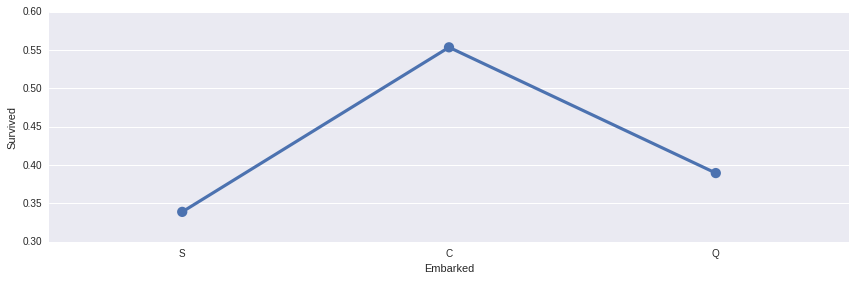

In [206]:
# Lets see what the average survival rate is for each of the embarked classes,
# I put a ci of 0 as this is just a mathematical average calculated from one sample, so reliability of the 
# observation doesn't seem to make sense to me
sns.factorplot('Embarked','Survived',data=titanic_df,size=4,aspect=3,ci=0)

Ok, next, lets try to compare number survivors from each embarked class.

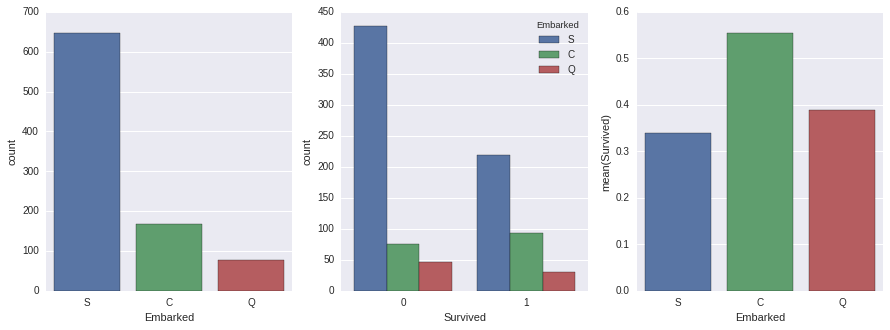

In [207]:
# First, create subplots of 3 figures, 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
# plot a count plot of people who embarked
sns.countplot("Embarked",data=titanic_df,ax=ax1)
# Next, count plot of people who survived and did not
sns.countplot("Survived",hue="Embarked", data=titanic_df,ax=ax2)
# Finally, just plot the average of all survivied embarked classes, same as out[37]
mean_df = titanic_df[['Embarked','Survived']].groupby('Embarked',as_index=False).mean()
sns.barplot(x="Embarked",y="Survived",data=mean_df,order=['S','C','Q'],ax=ax3)


In [208]:
# Now, the Embarked field is a nominal feature, replace this feature with a binary represention, similar to
# OneHotEncoder in sklearn.preprocessing
embark_dummies_titanic=pd.get_dummies(titanic_df['Embarked'])
embark_dummies_test = pd.get_dummies(test_df['Embarked'])
titanic_df = titanic_df.join(embark_dummies_titanic)
test_df = test_df.join(embark_dummies_test)
titanic_df.drop(['Embarked'],axis=1,inplace=True)
test_df.drop(['Embarked'],axis=1,inplace=True)

In [209]:
#Fare

# Check if the test data requires any imputing
test_df.isnull().sum()

Pclass      0
Sex         0
Age        86
SibSp       0
Parch       0
Fare        1
Cabin     327
C           0
Q           0
S           0
dtype: int64

In [210]:
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

In [211]:
# Get fare of those who survived and didn't
fares_survived =titanic_df[titanic_df["Survived"] == 1]["Fare"]
fares_not_survived = titanic_df[titanic_df["Survived"] == 0]["Fare"]

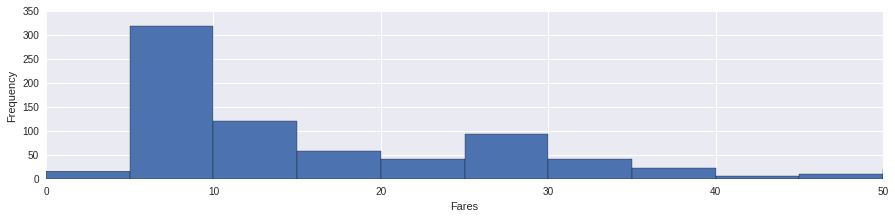

In [212]:
# Plot the fares now
data=titanic_df["Fare"].values
plt.rcParams["figure.figsize"] = (15,3)
plt.hist(data,bins=range(min(data), max(data) + 5, 5))
plt.xlim((0,50))
plt.xlabel("Fares")
plt.ylabel("Frequency")

In [213]:
# get average and std for fare of survived/not survived passengers,
avg_fare = pd.DataFrame([fares_not_survived.mean(), fares_survived.mean()],columns=['Survived'])
std_fare      = pd.DataFrame([fares_not_survived.std(), fares_survived.std()],columns=['Survived'])

(-1, 2)

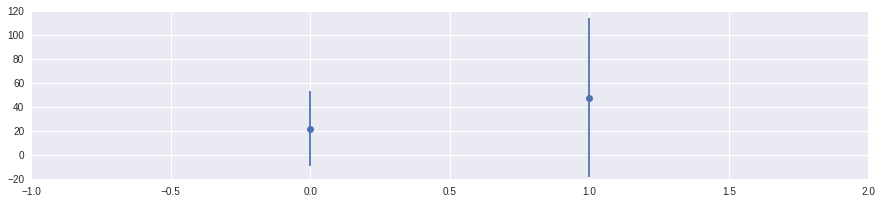

In [214]:
# Plot an error to compare what was the average cost of the fare paid by people who didnt survive and survived.
plt.errorbar(x=[0,1],y=avg_fare['Survived'].values,yerr=std_fare['Survived'].values,linestyle='None',marker='o')
plt.xlim([-1,2])

We can see above that People who survived appear to have paid a higher fare on an average. 

### Analysing the Age feature  
What about age? Surely this seems like a good determinant for survival.  
Now age has a lot a missing values, and we need to impute the missing values.  
It would make more sense to randomly populate the missing ages from the distribution of ages in the dataset.  
  
Lets take the random numbers assuming a normal distribution of ages, which we can get usiing the sample mean and sample std deviation.   

In [216]:
# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
missing_ages_titanic = titanic_df["Age"].isnull().sum()

In [217]:
# similarly get average,std and number of NaN valies in test_df
average_age_test = test_df["Age"].mean()
std_age_test = test_df["Age"].std()
missing_ages_test = test_df["Age"].isnull().sum()

In [218]:
# get random values for age for both test and train sets
rand_age_train = (std_age_titanic*np.random.randn(missing_ages_titanic) + average_age_titanic)
rand_age_test = (std_age_test*np.random.randn(missing_ages_test) + average_age_test)
# Since this may generate negitive values, make any negitive value as 0
rand_age_train[rand_age_train<0] = 0
rand_age_test[rand_age_test<0] = 0

Lets quickly see how this imputing would affect the data that we have currently  

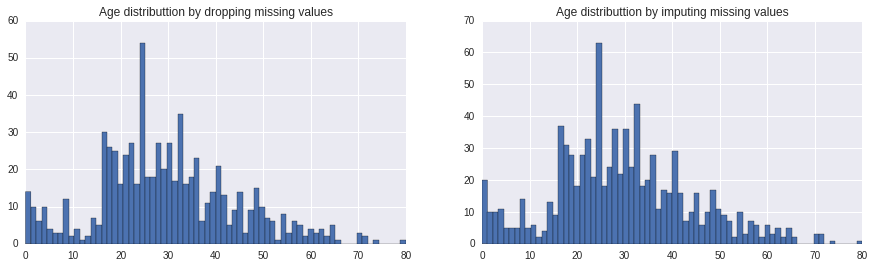

In [219]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
titanic_df["Age"].dropna().astype(int).hist(ax=ax1,bins=70)
ax1.set_title('Age distributtion by dropping missing values')

# Now visualize with the randomly generated values
# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_age_train
test_df["Age"][np.isnan(test_df["Age"])] = rand_age_test

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=ax2)
ax2.set_title('Age distributtion by imputing missing values')

We can see that this has more or less retained the origional shape of the disribution

/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


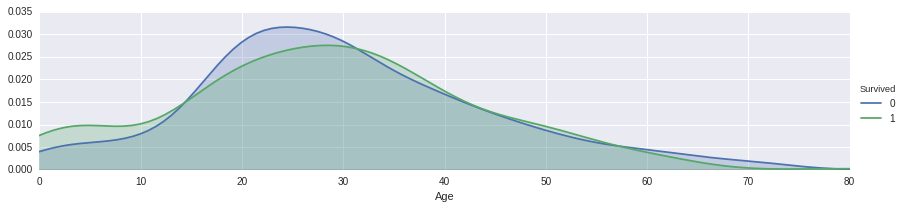

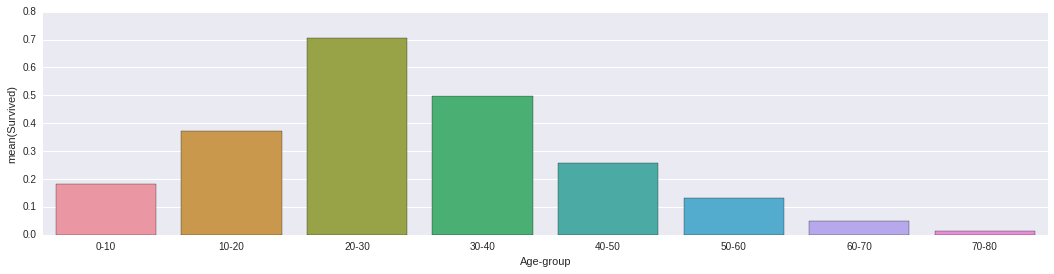

In [281]:
from sklearn.preprocessing import normalize

# Now lets plot the kernel density plot for age over the Survived feature
fg = sns.FacetGrid(titanic_df,hue="Survived",aspect=4)
fg.map(sns.kdeplot,"Age",shade=True)
fg.set(xlim=(0,titanic_df["Age"].max()))
fg.add_legend()

# Plot survival for ranges of age groups
# Eg like 0-10,10-20... etc
avg_bins = titanic_df["Age"].groupby(pd.cut(titanic_df["Age"],[0,10,20,30,40,50,60,70,80])).count()
avg_array = normalize([avg_bins.as_matrix()])
avg_array=avg_array[0]
age_range = [ str(i*10) +'-'+str(10*(i+1)) for i in range(0,len(avg_array))]
avg_df = pd.DataFrame({'Survived':avg_array,'Age-group':age_range})

fig, axis1 = plt.subplots(1,1,figsize=(18,4))
sns.barplot(x='Age-group',y='Survived',data=avg_df)

### Cabin  
This feature has a lot of missing values and doesn't seem to be of much use, so lets drop it.  

In [282]:
titanic_df.drop('Cabin',axis=1,inplace=True)
test_df.drop('Cabin',axis=1,inplace=True)

### Family  
Combine the sibsp and parch features into a single feature called family.  
We can analyse if having any family member increases the chance of survival

In [285]:
titanic_df["Family"] = titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df["Family"][titanic_df["Family"] > 0] = 1
titanic_df["Family"][titanic_df["Family"] == 0] = 0

In [288]:
# Do the same for test_df
test_df["Family"] = test_df["Parch"] + test_df["SibSp"]
test_df["Family"][test_df["Family"] > 0] = 1
test_df["Family"][test_df["Family"] == 0] = 0

In [290]:
# drop the sibsp and parch features
titanic_df.drop(["SibSp","Parch"],axis=1,inplace=True)
test_df.drop(["SibSp","Parch"],axis=1,inplace=True)

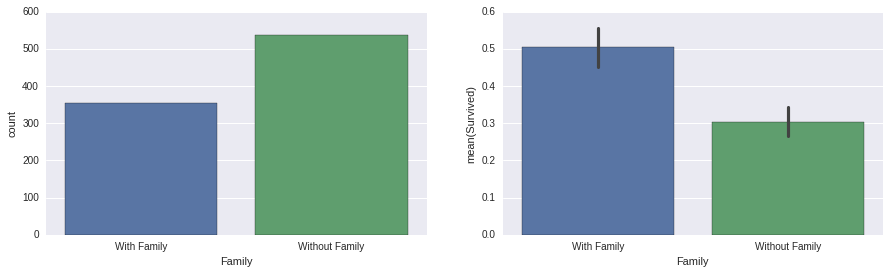

In [307]:
# Plot this data
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharex=True,figsize=(15,4))
sns.countplot("Family",data=titanic_df,order=[1,0],ax=ax1)
family_survival_avgs = titanic_df[["Family","Survived"]].groupby("Family",as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=titanic_df,order=[1,0],ax=ax2)
ax1.set_xticklabels(['With Family','Without Family'])

### Sex  
While analysing based on sex, it does seem logical to classify passengers as male, female and child.  
While age<18 is techbically a child, lets assume the age 16 to what might appear as a child  
Now, these are nominal features, so we can encode them as binary variables.


In [319]:
# Let's create a new feature called MFC, which is male female or child
# We shall later encode them in binary like how we did with Embarked
get_mfc = lambda person: person[1]<=16 and "child" or person[0]
titanic_df["MFC"] = titanic_df[['Sex','Age']].apply(get_mfc,axis=1 )
test_df["MFC"] = test_df[['Sex','Age']].apply(get_mfc,axis=1 )

In [322]:
# Next, convert the nominal features to binary via pd.get_dummies
train_mfc = pd.get_dummies(titanic_df["MFC"])
test_mfc= pd.get_dummies(test_df["MFC"])
titanic_df.drop(["Sex"],axis=1,inplace=True)
test_df.drop(["Sex"],axis=1,inplace=True)

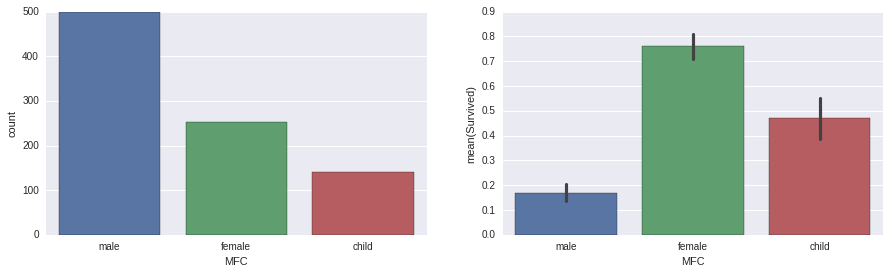

In [331]:
# Plot this data
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
# plot the number of male female and children
sns.countplot("MFC",data=titanic_df,order=['male','female','child'],ax=ax1)
# plot the survival average for male,female,child
avg_df = titanic_df[['Survived','MFC']].groupby("MFC",as_index=False).mean()
sns.barplot(x="MFC",y="Survived",data=titanic_df,order=['male','female','child'],ax=ax2)


From above we can see that male has a very low average, this would mean that our model would perform poorly on the data. Hence we drop male from the features.

In [333]:
train_mfc.drop("male",axis=1,inplace=True)
test_mfc.drop("male",axis=1,inplace=True)

In [339]:
# join to the dataset
titanic_df, test_df = titanic_df.join(train_mfc), test_df.join(test_mfc)
titanic_df.drop("MFC",axis=1,inplace=True)
test_df.drop("MFC",axis=1,inplace=True)

In [344]:
#Lets see what our dataset looks like
titanic_df.head()

,Survived,Pclass,Age,Fare,C,Q,S,Family,child,female
0,0,3,22,7,0,0,1,1,0,0
1,1,1,38,71,1,0,0,1,0,1
2,1,3,26,7,0,0,1,0,0,1
3,1,1,35,53,0,0,1,1,0,1
4,0,3,35,8,0,0,1,0,0,0


### Pclass  
The last variable, this is the socio economic class variable to analyse.  
Note these are also ordinal features and we shall encode them to binary